In [2]:
!pip install music21==5.5.0
!pip install tensorflow==2.7.0
!pip install keras==2.7.0
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 6.5 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=8f7e8bc4ee4bdc00ad59432ae2417673507a032ad42fed9c9803f495c96ce7f9
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [3]:
import glob
import collections
import datetime
# import fluidsynth
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
from music21 import converter, instrument, note, chord, stream
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
def read_midi(file_):
    midi = converter.parse(file_)
    parts = instrument.partitionByInstrument(midi)
    if parts:
        notes = parts.parts[0].recurse()
    else:
        notes = midi.flat.notes
    return notes


def read_notes(files):
    notes = []
    for f in glob.glob(files):
        notes_to_parse = read_midi(f)
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
            else:
                continue
    return notes


def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})



In [9]:
notes = read_notes("/content/drive/MyDrive/ai/project/project/tschai/*.mid")
len(notes)

12521

In [16]:

# This chunk of code is taken from official Tensorflow documentation
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

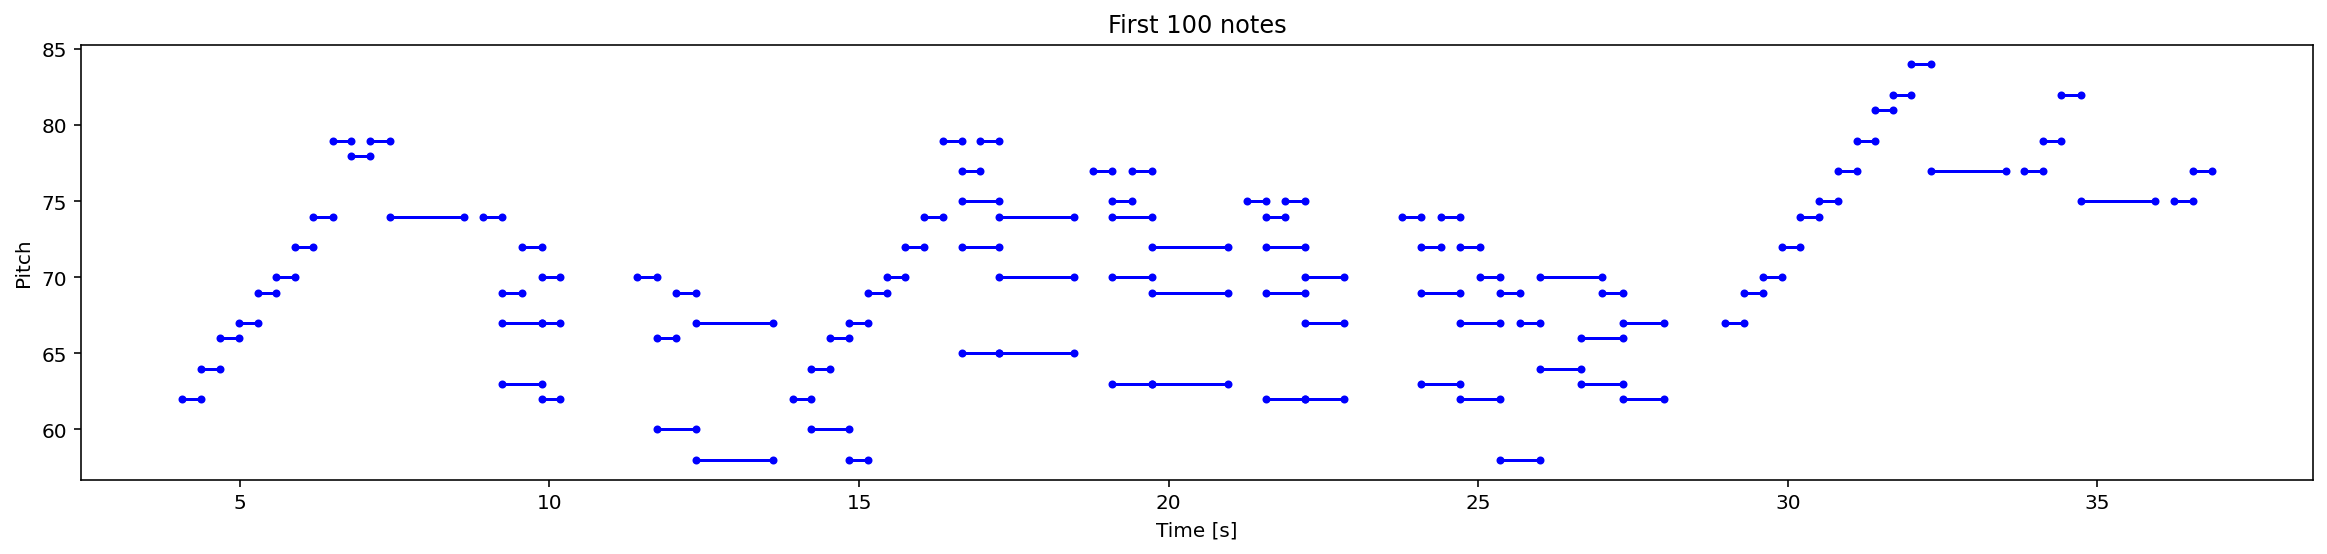

In [17]:
raw = midi_to_notes("/content/drive/MyDrive/ai/project/project/tschai/ty_juni.mid")
plot_piano_roll(raw, count=100)

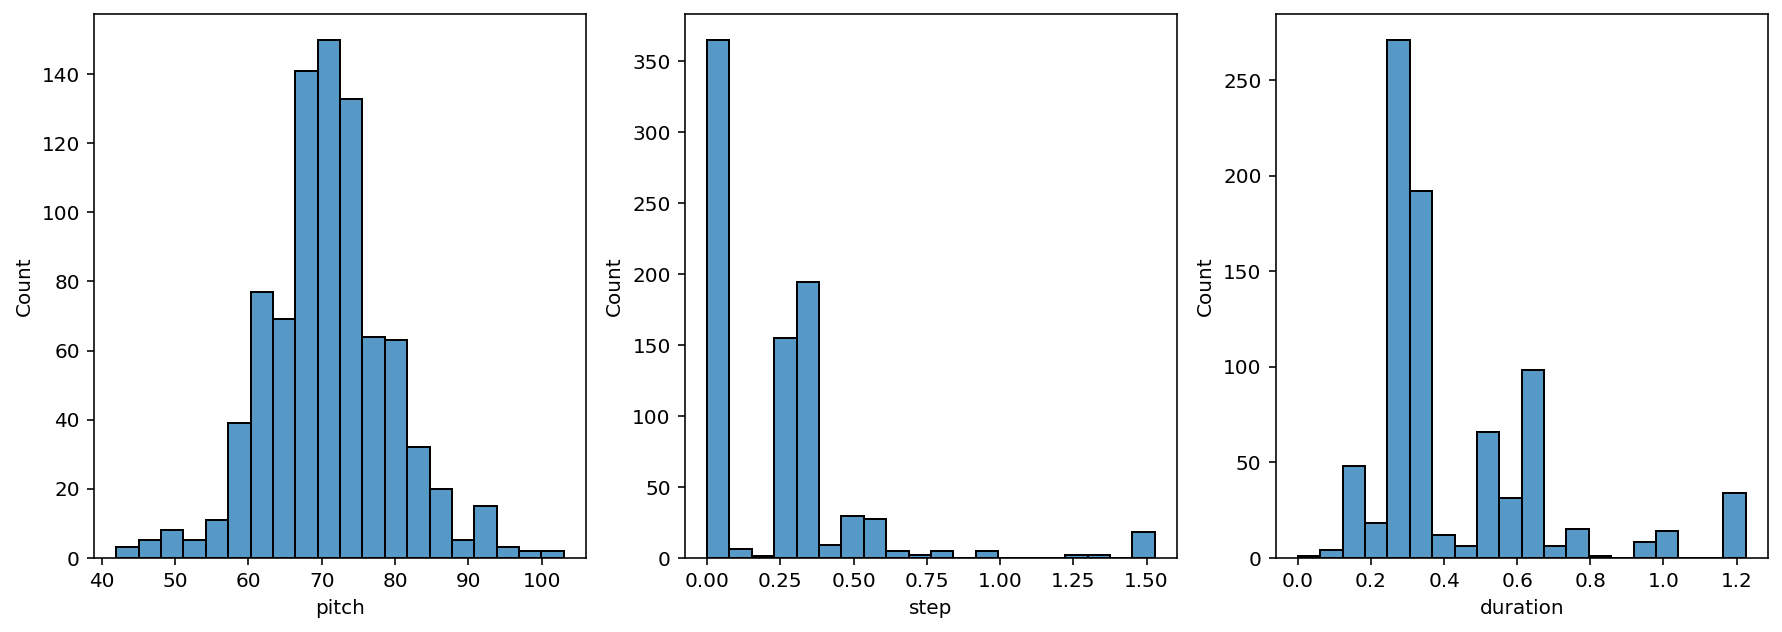

In [18]:
plot_distributions(raw)

## Generating music by predicting fixed-length pitches using LSTM

In [5]:
def create_notes_input_and_output(sequence_length, notes):

    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    network_input = []
    network_output = []

    for i in range(0, len(notes) - sequence_length):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    #Formulating inputs and outputs to be compatible with the model
    n_patterns = len(network_input)
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_vocab)

    network_output = to_categorical(network_output)
    return network_input, network_output

In [7]:

sequence_length = 100
pitchnames = sorted(set(item for item in notes))
n_vocab = len(pitchnames)

network_input, network_output = create_notes_input_and_output(sequence_length, notes)

In [14]:
# Defining the model

def define_the_model_3LSTM():
    model = Sequential()
    model.add(LSTM(
        256,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))

    model.add(Dropout(0.3))
    model.add(LSTM(256))

    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

def define_the_model_2LSTM():
    model = Sequential()
    model.add(LSTM(
        256,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

model=None
model = define_the_model_3LSTM()

In [15]:
# Training the model

filepath = "./checkpoints/tschai/test/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=1, batch_size=64, callbacks=callbacks_list)

195/195 [==============================] - 631s 3s/step - loss: 4.7545


In [ ]:
# Trying out different sequence lengths

for sequence_len in (50, 100, 150):
  network_input, network_output = create_notes_input_and_output(sequence_length, notes)

  define_the_model_3LSTM()

  # Trying out model with different number of LSTM layers
  # define_the_model_2LSTM()

  filepath = f"./checkpoints/tschai/test/sequence_len={sequence_len}-weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
  checkpoint = ModelCheckpoint(
      filepath, monitor='loss', 
      verbose=0,        
      save_best_only=True,        
      mode='min'
  )    
  callbacks_list = [checkpoint]     
  model.fit(network_input, network_output, epochs=100, batch_size=64, callbacks=callbacks_list)



In [ ]:
# Loading the weights into the model

model = define_the_model()
model.load_weights('/Users/Marta/Desktop/AI/project/checkpoints/tschai/regular_model_seq_100/weights-improvement-34-0.0543-bigger.hdf5')

In [16]:
notes_num = 500
start = numpy.random.randint(0, len(network_input)-1)

def predict_notes(start, number_of_notes):
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    prediction_output = []

    for note_index in range(number_of_notes):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
        prediction = model.predict(prediction_input, verbose=0)

        indexes = numpy.argsort(-prediction)[0][:3]
        index = indexes[0]

        result = int_to_note[index]
        prediction_output.append(result)
        pattern = numpy.append(pattern, index)
        pattern = pattern[1:len(pattern)]
    return prediction_output


prediction_output = predict_notes(start, notes_num)

In [17]:
def create_new_note_sequence(prediction_output, offset_step):
    offset = 0
    output_notes = []

    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        offset += offset_step
    return output_notes

output_notes = create_new_note_sequence(prediction_output, 0.5)

In [19]:
def write_notes_to_midi(output_notes, filename):
  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp=filename)

In [20]:
write_notes_to_midi(output_notes, './checkpoints/tschai/test/test_output?.mid')

### Generating music by predicting pitches, duration and offset of each note or chord

In [ ]:
# The following chunk of code was taken from the official
# Tensorflow music generation tutorial with a couple of modifications.

def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=2, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']
  
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)
  

In [ ]:
all_notes = []
for file_ in glob.glob("/content/drive/MyDrive/ai/project/project/tschai/*.mid"):
  notes = midi_to_notes(file_)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)


In [ ]:
def create_training_dataset(sequence_length):
    vocab_size = 128
    seq_ds = create_sequences(notes_ds, sequence_length, vocab_size)

    train_ds = (seq_ds
                .shuffle(len(all_notes) - sequence_length)
                .batch(64, drop_remainder=True)
                .cache()
                .prefetch(tf.data.experimental.AUTOTUNE))
    return train_ds


sequence_length = 100
train_ds = create_training_dataset(sequence_length)

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
def define_the_3D_sequence_model(seq_length):
  input_shape = (seq_length, 3)
  learning_rate = 0.005

  inputs = tf.keras.Input(input_shape)
  x = Sequential(
      [LSTM(128, return_sequences=True), Dropout(0.2), LSTM(128), Dense(128)]
  )(inputs)

  outputs = {
    'pitch': Dense(128, name='pitch')(x),
    'step': Dense(1, name='step')(x),
    'duration': Dense(1, name='duration')(x),
  }

  model = tf.keras.Model(inputs, outputs)

  loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
  }

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=loss, optimizer=optimizer)
  model.summary()
  return model


In [ ]:
filepath = "./checkpoints/movie_osts/test/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     

%%time
epochs = 100
model = define_the_3D_sequence_model(100)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
def create_output(start_):

    start_ = "/content/drive/MyDrive/ai/project/project/tschai/ty_april.mid"
    pm = pretty_midi.PrettyMIDI(start_)
    instrument = pm.instruments[0]
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

    raw_notes = midi_to_notes(sample_file)

    num_predictions = 500

    sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

    # The initial sequence of notes; pitch is normalized similar to training
    # sequences
    input_notes = (
        sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

    generated_notes = []
    prev_start = 0
    for _ in range(num_predictions):
      pitch, step, duration = predict_next_note(input_notes, model, 1.0)
      # duration += np.random.random()
      start = prev_start + step
      end = start + duration
      input_note = (pitch, step, duration)
      generated_notes.append((*input_note, start, end))
      input_notes = np.delete(input_notes, 0, axis=0)
      input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
      prev_start = start

    generated_notes = pd.DataFrame(
        generated_notes, columns=(*key_order, 'start', 'end'))


    out_file = 'output.mid'
    out_pm = notes_to_midi(
        generated_notes, out_file=out_file, instrument_name='Acoustic Grand Piano')

    from google.colab import files
    files.download(out_file)